# Propagation d'incertitudes dans une chaîne de Markov

## Résumé 

Dans ce document, on présente comment simuler une chaîne de Markov à l'aide d'une fonction de saut. Cette chaîne de Markov est semblable à celle associée à un Piecewise Deterministic Markov Process (PDMP) utilisé en fiabilité dynamique. Ce document utilise une implémentation fondée sur le module otmarkov.

## Références

* Demgne, Jeanne Ady. Modélisation d’actifs industriels pour l’optimisation robuste de stratégies de maintenance. Thèse de doctorat. Pau, 2015.
* Davis, Mark HA. "Piecewise‐deterministic Markov processes: a general class of non‐diffusion stochastic models." Journal of the Royal Statistical Society: Series B (Methodological) 46.3 (1984): 353-376.

## Description

On considère une chaîne de Markov ainsi construite. 

L'état du système au début du n-ème saut est constitué 
* d'un vecteur aléatoire $\boldsymbol{U}_n$,
* d'un vecteur déterministe $\boldsymbol{v}_n$. 

Le vecteur aléatoire $\boldsymbol{U}_n$ est ici constitué de trois marginales indépendantes :
* $K_n$ de loi Gaussienne,
* $P_n$ de loi Gaussienne,
* $R_n$ de loi Weibull tronquée.

Le vecteur déterministe $\boldsymbol{v}_n$ est constitué d'une variable déterministe :

* $y_n\in\mathbb{R}$.

L'état déterministe initial est donné par l'équation 
$$
y_1 = 0.
$$

A chaque saut de la chaîne de Markov, nous générons une réalisation du vecteur aléatoire $\boldsymbol{U}_n$ et appliquons la fonction de transition $\boldsymbol{\Phi}$ pour connaître la valeur du vecteur déterministe $\boldsymbol{v}_{n+1}$. Dans notre application, on considère 3 sauts :

$$
m = 3.
$$

Dans cette chaîne de Markov, l'état à la fin du n-ème saut est déterminé par la fonction de transition $\Phi$ :

$$
\boldsymbol{v}_{n+1} = \boldsymbol{\Phi}(\boldsymbol{U}_n, \boldsymbol{v}_n),
$$
pour $n=1,...,m$. 

Dans notre application, la fonction de transition est définie par :

$$
\boldsymbol{\Phi}(\boldsymbol{U}_n, y_n) = y_n + \tau (1 - R_n) K_n P_n,
$$

où $\boldsymbol{U}_n = (K_n, P_n, R_n)\in\mathbb{R}^3$ et $\tau$ est une constante égale à 

$$
\tau = 12.
$$

Nous nous intéressons à la variable aléatoire $Y_4$, c'est à dire à la valeur de la variable $Y_n$ au terme des $m=3$ sauts. 

Nous considérons deux quantités d'intérêt :
* l'espérance de $Y_4$ : $\mathbb{E}(Y_4)$,
* la probabilité que $Y_4$ soit plus grande qu'un seuil donné : $\mathbb{P}(Y_4 > y_{lim})$.

Dans notre application, nous considérons le seuil limite :
$$
y_{lim}=14.
$$

In [1]:
import openturns as ot
import otmarkov

Fonction de transition
---

Fonction qui permet d'aller de l'état courant à l'état suivant.

In [2]:
def step_function(state, X):
    """
    Perform one step.

    Parameters
    ----------
    state : ot.Point(1)
        The current state.
    X : ot.Point(3)
        The random input.

    Returns
    -------
    new_state : ot.Point(1)
        The new state.

    """
    tau = 10.0
    K, P, R = X
    new_state = state + tau * (1.0 - R) * K * P
    return new_state


y1 = 0.0  # Etat initial
K = 0.85
P = 2.0
R = 0.45
X = [K, P, R]
new_y = step_function(y1, X)
new_y

9.35

## Distributions  des variables aléatoires K, P et R

In [3]:
dist_K = ot.Normal()
dist_P = ot.Normal()
dist_R = ot.WeibullMin()
Rmin = 1.0
dist_R = ot.TruncatedDistribution(dist_R, Rmin, ot.TruncatedDistribution.UPPER)

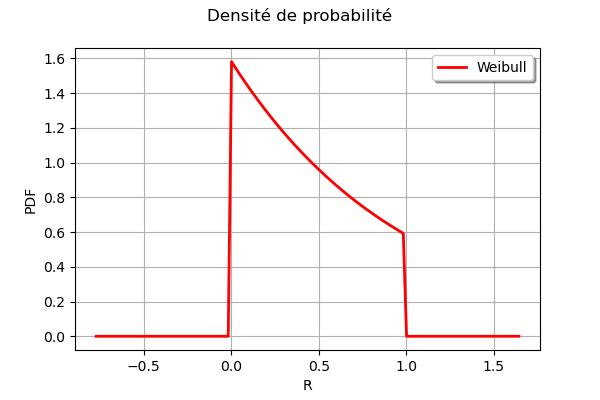

In [4]:
graph = dist_R.drawPDF()
graph.setLegends(["Weibull"])
graph.setTitle("Densité de probabilité")
graph.setXTitle("R")
graph

Création du vecteur aléatoire
---

In [5]:
# Variable d'état aléatoire
distribution = ot.ComposedDistribution([dist_K, dist_P, dist_R])

In [6]:
initial_state = 0.0

number_of_steps = 3

mc_random_vector = otmarkov.MarkovChainRandomVector(
    step_function, distribution, number_of_steps, initial_state
)
random_vector = ot.RandomVector(mc_random_vector)

## Estimation de la sortie moyenne

On souhaite estimer la moyenne de la sortie par un plan d'expériences de type Monte-Carlo simple. 

In [7]:
# Estime la sortie moyenne
sampleSize = 1000
outputSample = random_vector.getSample(sampleSize)
print("Sortie Moyenne = %f" % (outputSample.computeMean()[0]))

Sortie Moyenne = -0.479506


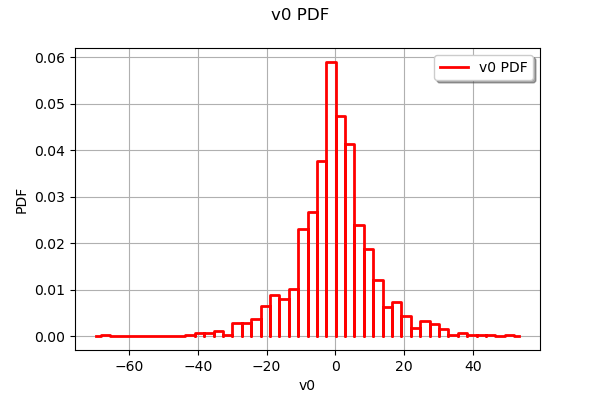

In [8]:
# Draw histogram
ot.HistogramFactory().build(outputSample).drawPDF()

Estimation de la probabilité de dépasser un seuil
---

On souhaite estimer la probabilité que la sortie dépasse un seuil par une méthode de Monte-Carlo simple.

In [9]:
markov_chain = otmarkov.MarkovChain(
    step_function, distribution, number_of_steps, initial_state
)
composite_random_vector = markov_chain.getOutputRandomVector()

In [10]:
Y_limite = 14.0
event = ot.ThresholdEvent(composite_random_vector, ot.Greater(), Y_limite)

In [11]:
# create a Monte Carlo algorithm
Nbsimu = 1000
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.01)
algo.setBlockSize(100)
algo.setMaximumOuterSampling(Nbsimu)
algo.run()

In [12]:
# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print("P(Y > Y_limite)=", probability)

P(Y > Y_limite)= 0.08317999999999993


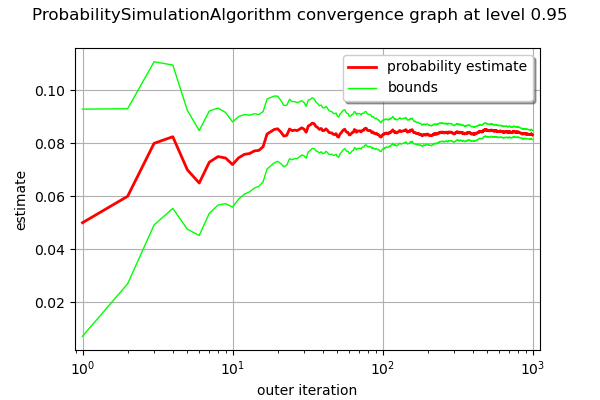

In [13]:
graph = algo.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
graph

Estimation de la sortie moyenne - plans d'expériences
---
On souhaite estimer la moyenne de la sortie et expérimenter différents plan d'expériences : Monte-Carlo simple et séquence de Sobol'.

In [21]:
distribution = markov_chain.getInputDistribution()
input_dimension = distribution.getDimension()
input_dimension

9

In [15]:
function = markov_chain.getFunction()
function.getInputDimension()

9

In [16]:
Nbsimu = 1000
ot.RandomGenerator.SetSeed(1)
myDOE = ot.MonteCarloExperiment(distribution, Nbsimu)
mySample = myDOE.generate()
Y = function(mySample)

Calcul de la moyenne de la sortie

In [17]:
yMoyenne = Y.computeMean()[0]
print("Y moyenne : %f" % (yMoyenne))

Y moyenne : 0.587896


Pour utiliser une séquence à faible discrépance, il suffit de reprendre le script précédent avec le plan d'expérience suivant.

In [22]:
Nbsimu = 1000
sequence = ot.SobolSequence(input_dimension)
experiment = ot.LowDiscrepancyExperiment(sequence, distribution, Nbsimu)
experiment.setRandomize(True)
mySample = experiment.generate()

In [23]:
ot.RandomGenerator.SetSeed(1)
Y = function(mySample)

In [24]:
yMoyenne = Y.computeMean()[0]
print("Y moyenne : %f" % (yMoyenne))

Y moyenne : 0.128708
